# lisabeta: examples for MBHB signal

## Imports

In [1]:
import os
import h5py
import itertools
import copy
import numpy as np
import json

from tqdm import tqdm as tqdm

from astropy.cosmology import Planck15 as cosmo

In [2]:
import lisabeta
import lisabeta.pyconstants as pyconstants
import lisabeta.tools.pytools as pytools
import lisabeta.tools.pyspline as pyspline
import lisabeta.tools.pyoverlap as pyoverlap
import lisabeta.lisa.pyresponse as pyresponse
import lisabeta.lisa.snrtools as snrtools
import lisabeta.lisa.pyLISAnoise as pyLISAnoise
import lisabeta.lisa.lisatools as lisatools
import lisabeta.lisa.lisa as lisa
import lisabeta.lisa.lisa_fisher as lisa_fisher
import lisabeta.utils.plotutils as plotutils

/Users/marsat/miniconda3/envs/lal-py310/lib/python3.10/site-packages/lisabeta-0.1-py3.10-macosx-10.9-x86_64.egg/lisabeta/waveforms/bbh/lalsim_wrap.py:10: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [3]:
%matplotlib inline

# Generate signal

## Setting parameters

In [4]:
# Redshift z=4
cosmo.luminosity_distance(4.).value

36697.03638699887

In [5]:
# Physical signal parameters

params = {
    # Total *redshifted* mass M=m1+m2, solar masses
    "M": 4e6,
    # Mass ratio q=m1/m2
    "q": 3.0,
    # Dimensionless spin component 1 along orbital momentum
    "chi1": 0.5,
    # Dimensionless spin component 2 along orbital momentum
    "chi2": 0.2,
    # Time shift of coalescence, s -- coalescence is at t0*yr + Deltat*s, t0 in waveform_params
    "Deltat": 0.0,
    # Luminosity distance, Mpc
    "dist": 3.65943e+04,
    # Inclination, observer's colatitude in source-frame
    "inc": 1.0471975511965976,
    # Phase, observer's longitude in source-frame
    "phi": 1.2,
    # Longitude in the sky
    "lambda": 0.8,
    # Latitude in the sky
    "beta": 0.3,
    # Polarization angle
    "psi": 1.7,
    # Flag indicating whether angles and Deltat pertain to the L-frame or SSB-frame
    "Lframe": True
  }

In [6]:
# Parameters for the waveform generation and other options

waveform_params = {
    # Frequency range
    "minf": 1e-5,
    "maxf": 0.5,
    # Reference epoch of coalescence, yr -- coalescence is at t0*yr + Deltat*s, Deltat in params
    "t0": 0.0,
    # Always cut signals timetomerger_max*yr before merger -- to avoid needlessly long signals using minf
    "timetomerger_max": 1.0,
    # Option to cut the signal pre-merger -- must be in L-frame
    "DeltatL_cut": None,
    # Further options to cut signals
    "fend": None,
    "tmin": None,
    "tmax": None,
    # Options for the time and phase alignment -- development/testing
    "phiref": 0.0,
    "fref_for_phiref": 0.0,
    "tref": 0.0,
    "fref_for_tref": 0.0,
    "force_phiref_fref": True,
    "toffset": 0.0,
    # TDI channels to generate
    "TDI": "TDIAET",
    # Internal accuracy params
    "acc": 1e-4,
    "order_fresnel": 0,
    # Waveform approximant and set of harmonics to use
    "approximant": "IMRPhenomHM",
    "modes": None,
    # LISA response options
    "LISAconst": "Proposal",
    "responseapprox": "full",
    "frozenLISA": False,
    "TDIrescaled": True,
    # Noise options -- can also be given as a numpy array for interpolation
    "LISAnoise": {
        "InstrumentalNoise": "SciRDv1",
        "WDbackground": False,
        "WDduration" : 0.0,
        "lowf_add_pm_noise_f0": 0.0,
        "lowf_add_pm_noise_alpha": 2.0
    }
  }

## Waveform and response generation function

In [7]:
# Generate waveform and LISA transfer functions separately
wftdi = lisa.GenerateLISATDI_SMBH(params, **waveform_params)

In [27]:
%timeit lisa.GenerateLISATDI_SMBH(params, **waveform_params)

1.78 ms ± 14.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [31]:
wftdi.keys()

dict_keys(['params', 'modes', 'fpeak', (2, 2), (2, 1), (3, 3), (3, 2), (4, 4), (4, 3)])

In [32]:
# List of modes
wftdi['modes']

[(2, 2), (2, 1), (3, 3), (3, 2), (4, 4), (4, 3)]

In [33]:
# Each mode has its own amplitude, phase, Doppler phase, transfer functions
wftdi[(2,2)].keys()

dict_keys(['freq', 'amp', 'phase', 'phaseRdelay', 'transferL1', 'transferL2', 'transferL3', 'tf'])

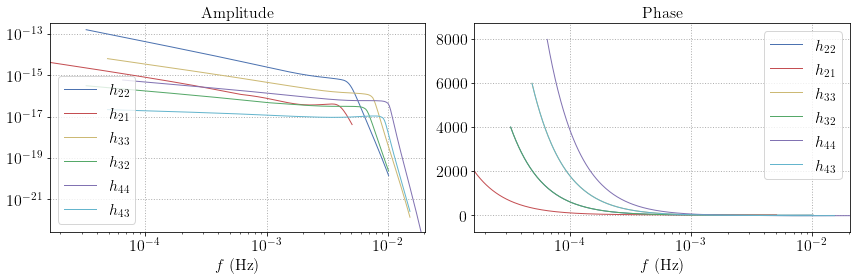

<Figure size 576x288 with 0 Axes>

In [41]:
# Amplitude and phase of the hlm in the waveform

labels = [r'$h_{22}$', r'$h_{21}$', r'$h_{33}$', r'$h_{32}$', r'$h_{44}$', r'$h_{43}$']
fig, axs = plt.subplots(1,2, figsize=[12,4])
plotutils.lloglogplot(axs[0], *[[wftdi[lm]['freq'], wftdi[lm]['amp']] for lm in wftdi['modes']], labels=labels)
plotutils.lloglinearplot(axs[1], *[[wftdi[lm]['freq'], wftdi[lm]['phase']] for lm in wftdi['modes']], labels=labels)
for i in range(2):
    axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
axs[0].legend(loc='lower left')
axs[1].legend(loc='upper right')
axs[0].set_title(r'Amplitude')
axs[1].set_title(r'Phase')
fig.tight_layout()

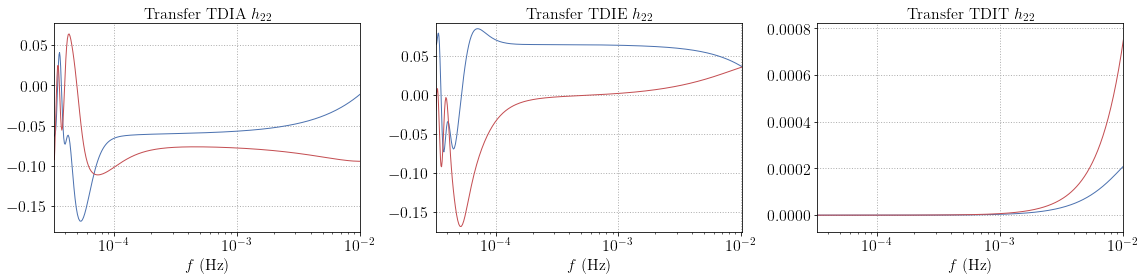

<Figure size 576x288 with 0 Axes>

In [38]:
# Transfer functions, mode h22 (NOTE: rescaled by (6*pi*f*L/c))
titles = ['Transfer TDIA $h_{22}$', 'Transfer TDIE $h_{22}$', 'Transfer TDIT $h_{22}$']
lm = (2,2)

L = 2.5e9
rescaling = 1./(6*np.pi*wftdi[(2,2)]['freq']*L/pyconstants.C_SI)

fig, axs = plt.subplots(1,3, figsize=[16,4])
for i in range(3):
    transferstr = 'transferL' + str(i+1)
    plotutils.lloglinearplot(axs[i], [wftdi[lm]['freq'], np.real(wftdi[lm][transferstr]) * rescaling], [wftdi[lm]['freq'], np.imag(wftdi[lm][transferstr]) * rescaling])
    axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
    axs[i].set_title(r'' + titles[i])
fig.tight_layout()

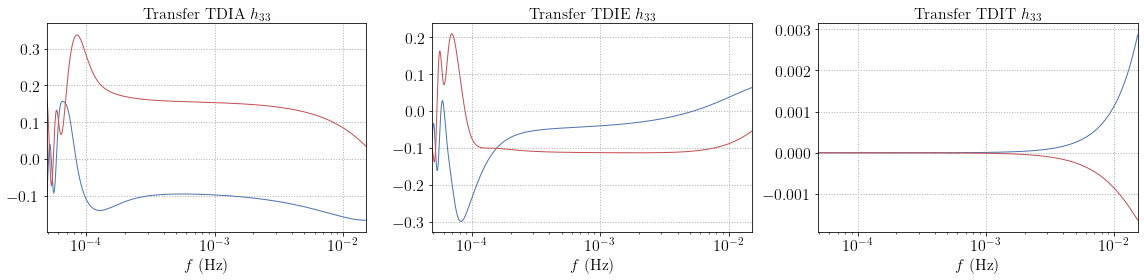

<Figure size 576x288 with 0 Axes>

In [39]:
# Transfer functions, mode h33 (NOTE: rescaled by (6*pi*f*L/c))
titles = ['Transfer TDIA $h_{33}$', 'Transfer TDIE $h_{33}$', 'Transfer TDIT $h_{33}$']
lm = (3,3)

L = 2.5e9
rescaling = 1./(6*np.pi*wftdi[(2,2)]['freq']*L/pyconstants.C_SI)

fig, axs = plt.subplots(1,3, figsize=[16,4])
for i in range(3):
    transferstr = 'transferL' + str(i+1)
    plotutils.lloglinearplot(axs[i], [wftdi[lm]['freq'], np.real(wftdi[lm][transferstr]) * rescaling], [wftdi[lm]['freq'], np.imag(wftdi[lm][transferstr]) * rescaling])
    axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
    axs[i].set_title(r'' + titles[i])
fig.tight_layout()

## Generate waveform and response, pre-process and compute SNR

In [25]:
tdisignal = lisa.GenerateLISATDISignal_SMBH(params, **waveform_params)

In [28]:
%timeit lisa.GenerateLISATDISignal_SMBH(params, **waveform_params)

6.2 ms ± 98.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [47]:
# Total SNR (all channels, all modes)
tdisignal['SNR']

993.2245850166325

In [34]:
tdisignal.keys()

dict_keys(['SNR', 'SNR2modematrix', 'wftdi', 'tdi', 'weightedtdi'])

In [42]:
# Matrix of (lm,l'm') mode contributions to the SNR^2
tdisignal['SNR2modematrix']

{'modes': [(2, 2), (2, 1), (3, 3), (3, 2), (4, 4), (4, 3)],
 'matrix': array([[ 8.35097917e+05, -2.45151107e+04,  1.31052142e+03,
          8.63839010e+03, -5.99534857e+02,  3.85477374e+00],
        [-2.45150953e+04,  2.78538045e+03,  1.30854914e+02,
         -3.06928548e+02,  4.40946179e+01, -6.41598858e+00],
        [ 1.31015451e+03,  1.30877978e+02,  1.34988304e+05,
         -2.78198301e+03,  1.58534392e+03,  3.62320619e+02],
        [ 8.63839010e+03, -3.06928692e+02, -2.78197420e+03,
          2.40779453e+03, -9.11682609e+01, -1.80228717e+00],
        [-5.99521929e+02,  4.40932562e+01,  1.58530767e+03,
         -9.11845467e+01,  4.41262240e+04, -2.95706509e+02],
        [ 3.84674390e+00, -6.41608989e+00,  3.62320619e+02,
         -1.80301715e+00, -2.95709283e+02,  1.36368221e+02]])}

In [46]:
# SNR in individual modes
list(zip(tdisignal['SNR2modematrix']['modes'], np.sqrt(np.diag(tdisignal['SNR2modematrix']['matrix']))))

[((2, 2), 913.8369204065997),
 ((2, 1), 52.77670368460306),
 ((3, 3), 367.40754467312183),
 ((3, 2), 49.06928295152541),
 ((4, 4), 210.06242880774178),
 ((4, 3), 11.677680456421664)]

# Fisher matrix

In [11]:
list_params = ['M', 'q', 'chi1', 'chi2', 'Deltat', 'dist', 'inc', 'phi', 'lambda', 'beta', 'psi']
params_complete = pytools.complete_mass_params(params)
params_complete = pytools.complete_spin_params(params_complete)

# Use frequency grid adjusted to inspiral phasing at low frequencies, logarithmic at high frequencies, with default number of points
freqs = ['nyquist_log', None]

# Do the computation in the L-frame
Lframe = True

steps = lisa_fisher.get_default_steps_smbh(params['M'])

steps

{'M': 4.000000000000002e-06,
 'Mchirp': 4.000000000000002e-06,
 'm1': 4.000000000000002e-06,
 'm2': 4.000000000000002e-06,
 'q': 0.00010000000000000009,
 'eta': 9.999999999999997e-06,
 'chi1': 9.999999999999997e-06,
 'chi2': 9.999999999999997e-06,
 'chip': 9.999999999999997e-06,
 'chim': 9.999999999999997e-06,
 'chis': 9.999999999999997e-06,
 'chia': 9.999999999999997e-06,
 'chiPN': 9.999999999999997e-06,
 'Deltat': 0.00010000000000000009,
 'dist': 9.999999999999997e-06,
 'inc': 0.00010000000000000009,
 'phi': 0.00010000000000000009,
 'lambda': 0.00010000000000000009,
 'beta': 0.00010000000000000009,
 'psi': 0.00010000000000000009}

In [15]:
%%time
fishercov = lisa_fisher.fisher_covariance_smbh(params, freqs=freqs, steps=steps, list_params=list_params, Lframe=Lframe, **waveform_params)

CPU times: user 1.37 s, sys: 157 ms, total: 1.53 s
Wall time: 1.28 s


In [76]:
fishercov.keys()

dict_keys(['params', 'list_params', 'fisher', 'cov', 'Lframe'])

In [78]:
# Fisher covariance matrix, 11*11
fishercov['list_params'], fishercov['cov']

(['M',
  'q',
  'chi1',
  'chi2',
  'Deltat',
  'dist',
  'inc',
  'phi',
  'lambda',
  'beta',
  'psi'],
 array([[ 2.17389503e+06,  4.54597444e+00,  6.26470042e-01,
         -4.43609677e-01, -2.38101274e+02, -1.92541990e+04,
         -1.07867069e+00,  6.38155250e+00,  7.67032878e-01,
         -9.17664534e-01,  4.32203949e+00],
        [ 4.54597444e+00,  1.29309769e-05,  5.96695043e-07,
         -1.68914762e-06, -1.03138480e-03, -5.53534384e-02,
         -3.94125334e-06,  2.13572227e-05,  1.62795867e-06,
         -2.66089559e-06,  1.02375066e-05],
        [ 6.26470042e-01,  5.96695043e-07,  6.03192055e-07,
         -2.54769585e-07,  1.81638232e-04,  3.50984409e-02,
          1.60961366e-07, -4.58260495e-06, -6.28053906e-07,
          4.63479593e-07, -3.08801964e-06],
        [-4.43609677e-01, -1.68914762e-06, -2.54769585e-07,
          1.60225876e-06,  1.34171861e-04, -1.54231278e-01,
          1.68908120e-06,  9.12528100e-06,  3.43331007e-06,
         -1.39311559e-06,  1.52015392e-05]

In [79]:
('M', np.sqrt(fishercov['cov'][0,0])/params_complete['M'])

('M', 0.0003686033629914572)

In [86]:
('q', np.sqrt(fishercov['cov'][1,1]))

('q', 0.003595966756597771)

In [80]:
('dist', np.sqrt(fishercov['cov'][5,5])/params_complete['dist'])

('dist', 0.004310470364249975)

# Likelihood

In [89]:
template_params = params.copy()
template_params['q'] *= (1 + 1e-3)

In [91]:
# Historic 0-noise likelihood
likelihood = lisa.LikelihoodLISASMBH(params, **waveform_params)

In [96]:
# Faster likelihood, based on residuals from a reference signal -- can also accomodate real data
likelihood_residuals = lisa.LikelihoodLISASMBH_LinearResiduals(params, ngrid=128, **waveform_params)

In [92]:
likelihood.lnL(template_params)

-8.218456165166572

In [93]:
likelihood_residuals.lnL(template_params)

-8.18616217114272

In [94]:
%timeit likelihood.lnL(template_params)

9.73 ms ± 309 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [95]:
%timeit likelihood_residuals.lnL(template_params)

2.56 ms ± 557 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Example Bayesian PE

Sampler `ptemcee` available at `https://github.com/SylvainMarsat/ptemcee`

## Interface and run parameters

Example `.json` submission file:
<code>{
  "source_params": {
    "M": 4e6,
    "q": 3.0,
    "chi1": 0.5,
    "chi2": 0.2,
    "Deltat": 0.0,
    "dist": 3.65943e+04,
    "inc": 1.0471975511965976,
    "phi": 1.2,
    "lambda": 0.8,
    "beta": 1.0471975511965976,
    "psi": 1.7,
    "Lframe": true
  },
  "waveform_params": {
    "minf": 1e-5,
    "maxf": 0.5,
    "t0": 0.0,
    "timetomerger_max": 1.0,
    "fend": null,
    "tmin": null,
    "tmax": null,
    "phiref": 0.0,
    "fref_for_phiref": 0.0,
    "tref": 0.0,
    "fref_for_tref": 0.0,
    "force_phiref_fref": true,
    "toffset": 0.0,
    "modes": null,
    "TDI": "TDIAET",
    "acc": 1e-4,
    "order_fresnel": 0,
    "approximant": "IMRPhenomHM",
    "LISAconst": "Proposal",
    "responseapprox": "full",
    "frozenLISA": false,
    "TDIrescaled": true,
    "LISAnoise": {
        "InstrumentalNoise": "SciRDv1",
        "WDbackground": false,
        "WDduration" : 0.0,
        "lowf_add_pm_noise_f0": 0.0,
        "lowf_add_pm_noise_alpha": 2.0
    }
  },
  "prior_params": {
    "list_params": ["M", "q", "chi1", "chi2", "Deltat", "dist", "inc", "phi", "lambda", "beta", "psi"],
    "infer_params": ["M", "q", "chi1", "chi2", "Deltat", "dist", "inc", "phi", "lambda", "beta", "psi"],
    "params_range": [[1e6, 1e7], [1., 10.], [-1.0, 1.0], [-1.0, 1.0], [-600.0, 600.0], [10e3, 100e3], [], [], [], [], []],
    "prior_type": ["uniform", "uniform", "uniform", "uniform", "uniform", "uniform", "sin", "uniform", "uniform", "cos", "uniform"],
    "wrap_params": null
  },
  "run_params": {
    "out_dir": "/Users/marsat/Projects/lisabeta/lisabeta/examples/ptemcee_smbh/",
    "out_name": "smbh_example",
    "sampler": "ptemcee",
    "sample_Lframe": true,
    "multimodal": true,
    "multimodal_pattern": "8modes",
    "p_jump": 0.5,
    "likelihood_method": "residuals",
    "likelihood_residuals_ngrid": 128,
    "skip_fisher": false,
    "init_method": "fisher",
    "init_scale_cov": 1.0,
    "zerolike": false,
    "n_temps": 10,
    "temp_max": null,
    "n_walkers": 64,
    "n_iter": 4000,
    "burn_in": 1000,
    "autocor_method": "autocor_new",
    "thin_samples": true,
    "upsample": 1,
    "seed": null,
    "print_info": true,
    "n_iter_info": 50,
    "output": true,
    "output_raw": true
  }
}
</code>

Run with `python <lisabeta>/lisabeta/inference/ptemcee_smbh.py example.json`

## Load results

In [100]:
subsdir = '/Users/marsat/Projects/lisabeta/examples/'
#datadir = '/Users/marsat/Projects/lisabeta/examples/'
datadir = '/Users/marsat/Projects/lisabeta/examples/long/'

In [101]:
subfile = subsdir + 'smbh_example_cc.json'
postfile = datadir + 'smbh_example.h5'

params_post = plotutils.load_params_posterior_lisa_smbh(subfile, postfile)

post_raw_file = datadir + 'smbh_example_raw.h5'

post_raw = {}
with h5py.File(post_raw_file, 'r') as hf:
    for p in params_post['prior_params']['infer_params']:
        post_raw[p] = hf[p][:]
    post_raw['lnL'] = hf['lnlike'][:]

In [52]:
params_post.keys()

dict_keys(['fishercov', 'injparams_SSBframe', 'injparams_Lframe', 'waveform_params', 'prior_params', 'run_params', 'post'])

In [53]:
params_post['post'].keys()

dict_keys(['M', 'q', 'chi1', 'chi2', 'Deltat', 'dist', 'inc', 'phi', 'lambda', 'beta', 'psi', 'lnL', 'lnpost', 'Lframe', 'm1', 'm2', 'Mchirp', 'eta', 'chis', 'chia', 'chip', 'chim', 'chiPN'])

## Likelihood values

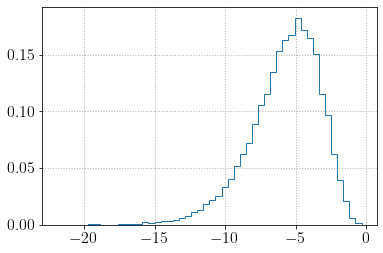

In [82]:
# We cheated with Fisher initialization, chains are good from the beginning !
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.hist(params_post['post']['lnL'], histtype='step', density=True);

In [58]:
def plot_postraw_lnL_trace(post_raw, rangey=None, title=''):

    nwalkers = post_raw['lnL'].shape[0]
    nsteps = post_raw['lnL'].shape[1]

    #Threshold to eliminate the -1e99 values that mess up plots
    masks = [post_raw['lnL'][i] > -1e12 for i in range(nwalkers)]
    fig, ax = plt.subplots(1,1, figsize=[16,4])
    plotutils.llogplot(ax, *[[np.arange(nsteps)[masks[i]], -post_raw['lnL'][i][masks[i]]] for i in range(nwalkers)], rangey=rangey)

    ax.set_xlabel(r'$\mathrm{Steps}$')
    ax.set_ylabel(r'$-\ln \mathcal{L}$')
    ax.set_title(title)

    return fig

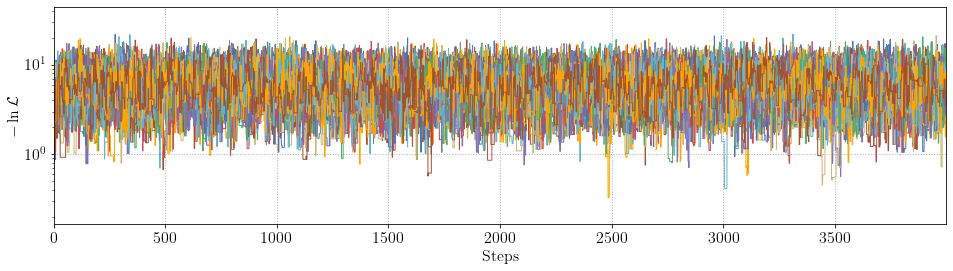

<Figure size 576x288 with 0 Axes>

In [83]:
# We cheated with Fisher initialization, chains are good from the beginning !
plot_postraw_lnL_trace(post_raw);

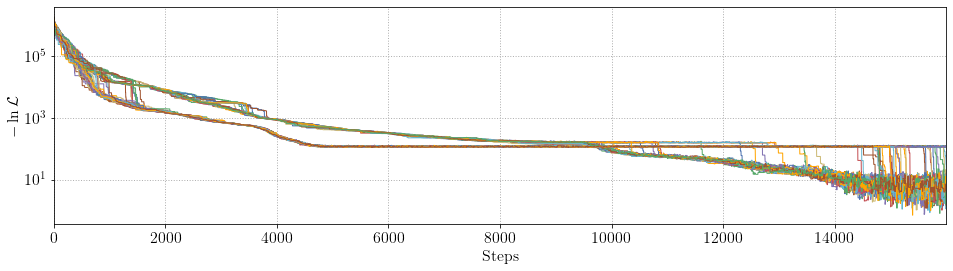

<Figure size 576x288 with 0 Axes>

In [103]:
# WARNING: at present burn-in hard for loud signals, can get stuck in secondary maxima (PT helps)

plot_postraw_lnL_trace(post_raw);

## Posterior

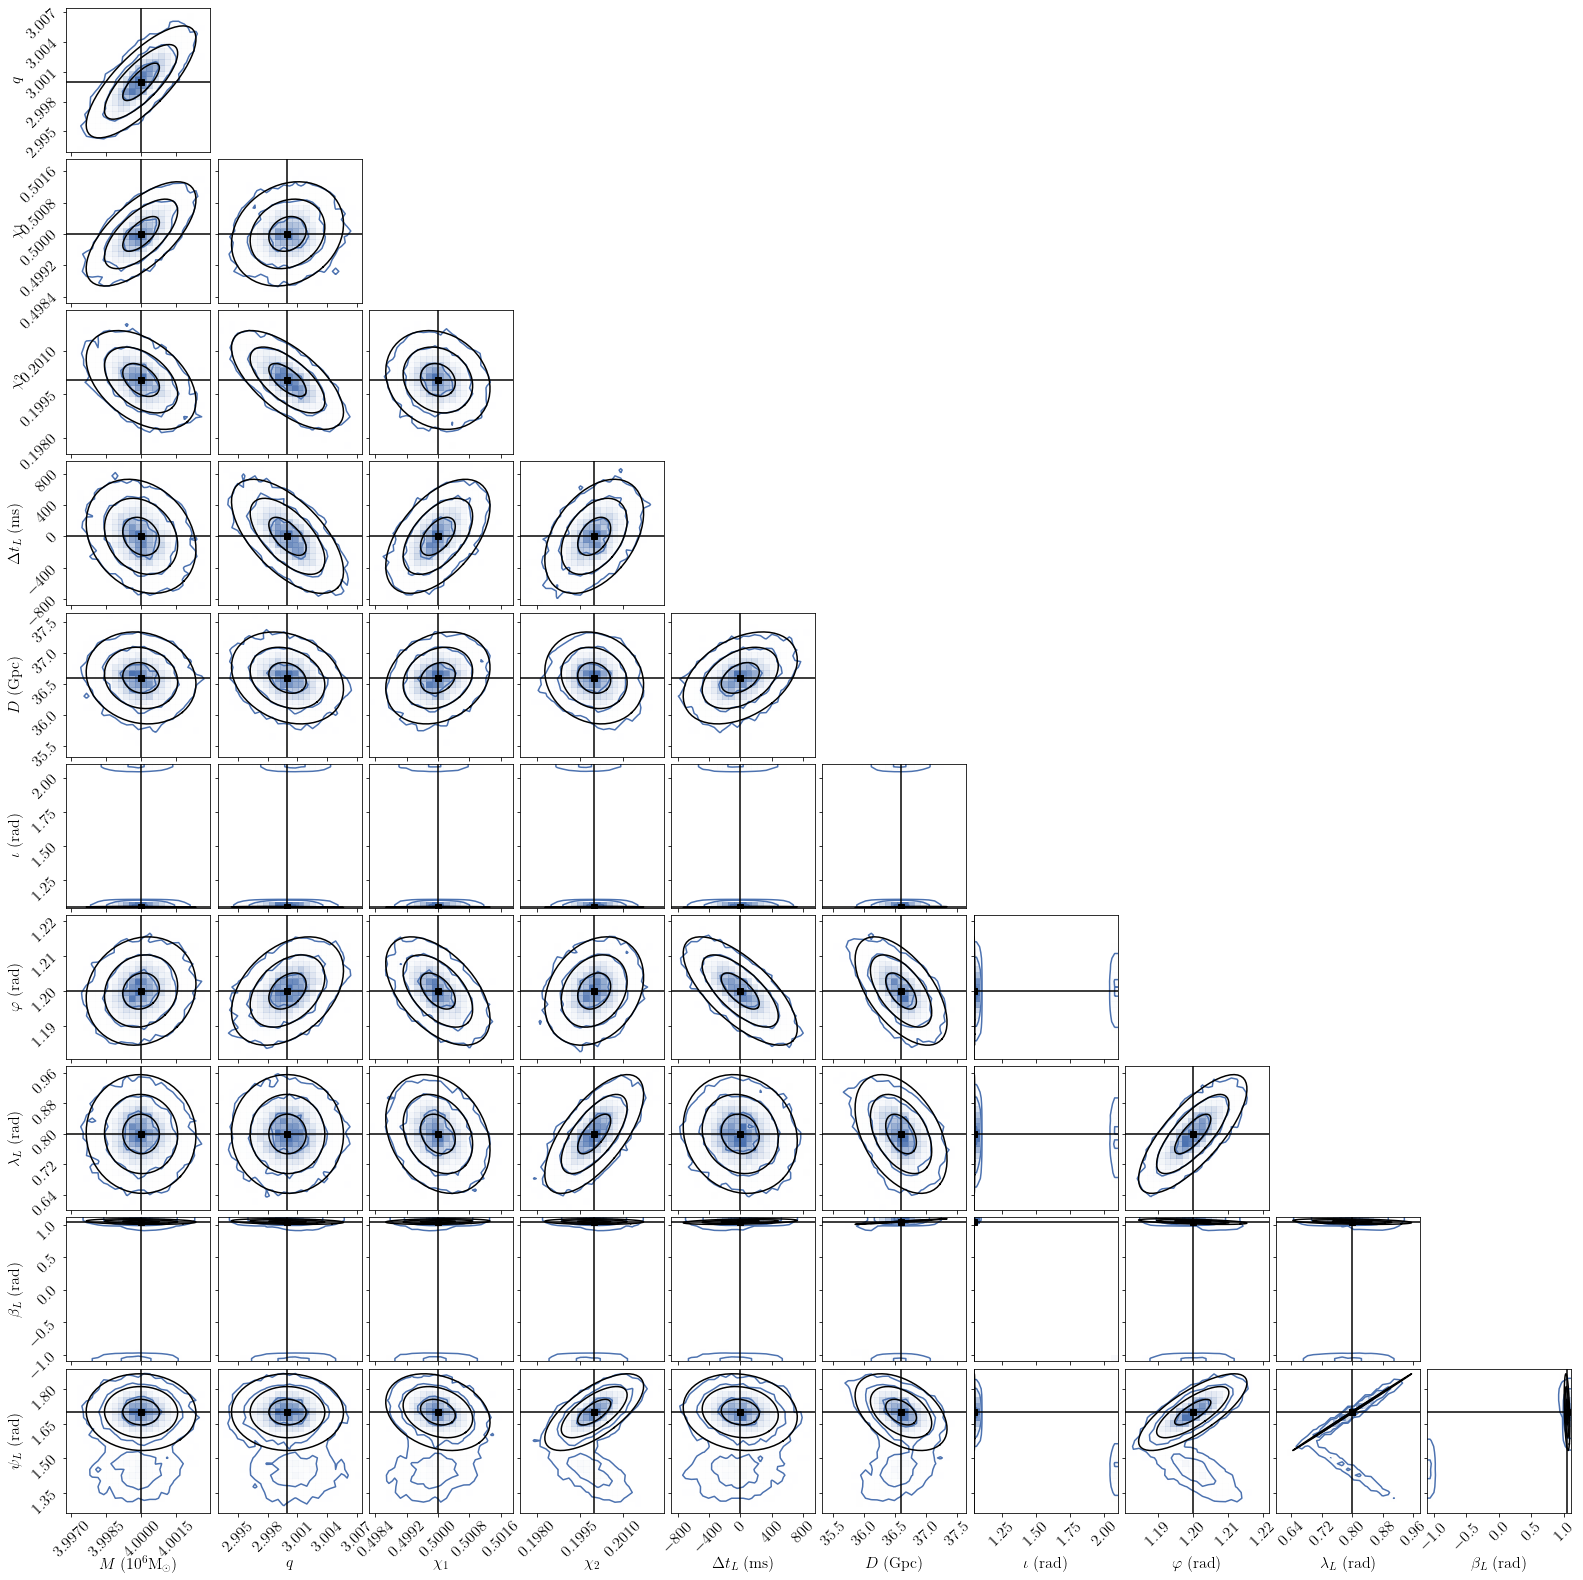

In [85]:
fig = plotutils.corner_plot(params_post['injparams_Lframe'], params_post['post'], output=False, histograms=True, fisher=True, fishercov=params_post['fishercov'], params=['M', 'q', 'chi1', 'chi2', 'Deltat', 'dist', 'inc', 'phi', 'lambda', 'beta', 'psi'], Lframe=True, color=plotutils.plotpalette[0], cov_color='k', show_truths=True, truth_color='k', bins=25, show_histograms=False, plot_datapoints=False);